# Path pattern generation using an Evolutionary computing aproach

in this module we will explore on how we can generate a valid sequence based on genetic and evolutionary computing.

## Libraries

In [25]:
import random
import numpy as np
import cv2 as cv
import ppg_init as ppg
import seqeval
import ipywidgets as widgets
import evolutionary_algorithms as ea
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

DEBUGMODE = False

## Fetch preprocessed data

In [2]:
number_gray = np.zeros((ppg.NO_DIGITS, ppg.IMG_WIDTH ,ppg.IMG_HEIGHT))
for i in range (ppg.NO_DIGITS):
    number_image = cv.imread(ppg.IMAGE_PATH+' '+str(i)+' dilated.png')
    number_gray[i] = cv.cvtColor(number_image, cv.COLOR_BGR2GRAY)

## Sample black pixels
there are two ways to sample the pixels. sampling based on their distribution, sampling them based on their sufficient black pixel in a subarea of the image and uniformly distribute them. here we try both and compare the results.

### Change resolution

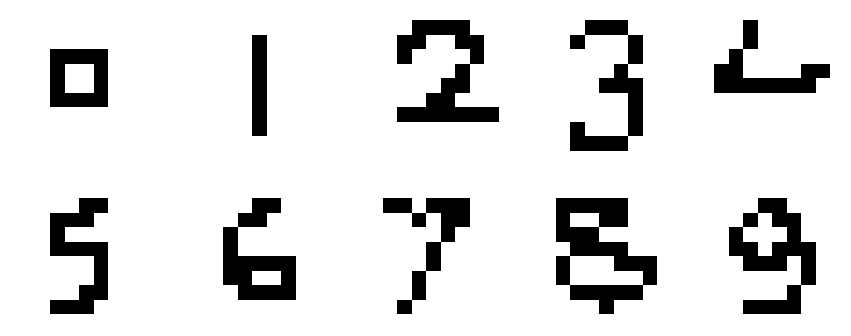

In [3]:
stride = 30
lrbp_threshold = 10 # low resolution black pixels threshold. 
# this is used when we want to count the number of the black pixels in the high resolution image
# and decide whether to mark the corresponding pixel in low resolution image black.
new_imgw = int(ppg.IMG_WIDTH/stride)
new_imgh = int(ppg.IMG_HEIGHT/stride)
new_img = np.ones((ppg.NO_DIGITS, new_imgw, new_imgh))*255
new_img2 = np.ones((ppg.NO_DIGITS, new_imgw, new_imgh))*255
# stride is always an odd number.

for i in range(ppg.NO_DIGITS):
    my_img = number_gray[i]
    # jump a 3,3 square and check for any black pixel within the area.

    for x in range(0, len(my_img), stride):
        for y in range(0, len(my_img[x]), stride):
            # stride is always an odd number.
            offset = int((stride-1)/2)
            new_x = int(x/stride)
            new_y = int(y/stride)
            black_pxl_vec = my_img[x-offset:x+offset+1,y-offset:y+offset+1]<50
            black_pxl_num = np.sum(black_pxl_vec)
#             print(has_black_pxl, end=' ')
            if(black_pxl_num>lrbp_threshold): # has at least one black pixel
                new_img[i,new_x,new_y] = 0
#         print(' ')
#     print('====================')
ppg.plot_digits(new_img)

### Initialize the sequence of the black pixels

In [4]:
sequence_num = []
for digit in range(10):
    sequence = []
    for row in range(len(new_img[digit])):
        for col in range(len(new_img[digit, row])):
            if new_img[digit, row, col]==0:
                sequence.append((row, col))
    sequence_num.append(sequence)
    if(DEBUGMODE):
        print('black pixels list for number ', digit, ':')
        print(sequence, '\n')
        
if(DEBUGMODE):
    print(sequence_num)

##### ranked based selection
with linear rank probability
$$\frac{(2-s)}{\mu} + \frac{(2 i (s-1)}{\mu (\mu - 1)}$$

with exponential rank probability
$$ \frac{1 - e ^ {-i}}{c} $$

## Training path generating

### Parameters selection:

In [5]:
ea.DIGIT=0
ea.P_MUTATION = 0.8
ea.P_CROSSOVER = 1.0
ea.POPULATION_SIZE = 100
ea.MAX_NUM_OF_GEN = 1000

### Training for separate digits

In [6]:
# (generation_profile, 
#     avg_fitness_profile, 
#     best_fitness_profile, 
#     best_ind_pheno_profile) = ea.train_evolve(mutation=ea.swap_mutation,
#                 crossover=ea.edge_recombination,
#                 parent_sel=ea.from_population_best_parents_select, 
#                 get_parents_pair_method=ea.get_parents_pair_duplocal,
#                 population_sel=ea.best_population_select, 
#                 population_init=ea.population_init, 
#                 population_terminate=ea.population_terminate, 
#                 vertices=sequence_num,
#                 desired_pheno=new_img,
#                 fitness_func=ea.fitness_func,
#                 geno2pheno=ea.geno2pheno)

In [7]:
# plt.plot(generation_profile,avg_fitness_profile)
# plt.ylim(0,210);

In [8]:
# plt.plot(generation_profile,best_fitness_profile)

In [9]:
# seqeval.draw_digit(best_ind_pheno_profile[-1], ppg.LOW_RESOLUTION_IMG_SIZE)

0.
generation = 26  progress: 2.6%  [#------------------------------------------------]       
1.
generation = 1  progress: 0.1%  [-------------------------------------------------]       
2.
generation = 325  progress: 32.5%  [################---------------------------------]       
3.
generation = 1000  progress: 100.0%  [##################################################]      
4.
generation = 89  progress: 8.9%  [####---------------------------------------------]       
5.
generation = 334  progress: 33.4%  [################---------------------------------]       
6.
generation = 178  progress: 17.8%  [########-----------------------------------------]       
7.
generation = 1000  progress: 100.0%  [##################################################]      
8.
generation = 268  progress: 26.8%  [#############------------------------------------]       
9.
generation = 1000  progress: 100.0%  [##################################################]      
10.


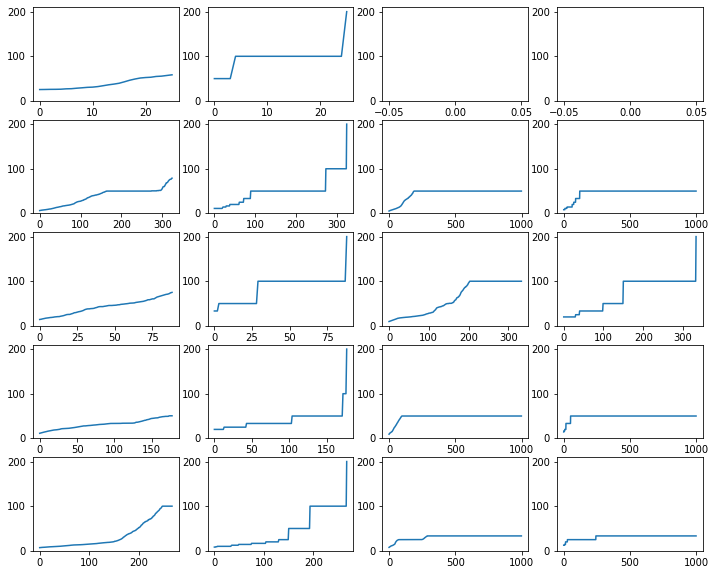

In [13]:
plt.figure(figsize=(12,10))
print(0,'.',sep='')
sol_num = []
for i in range(ppg.NO_DIGITS):
    ea.DIGIT=i
    (generation_profile, 
    avg_fitness_profile, 
    best_fitness_profile, 
    best_ind_pheno_profile) = ea.train_evolve(mutation=ea.swap_mutation,
                crossover=ea.edge_recombination,
                parent_sel=ea.from_population_best_parents_select, 
                get_parents_pair_method=ea.get_parents_pair_duplocal,
                population_sel=ea.best_population_select, 
                population_init=ea.population_init, 
                population_terminate=ea.population_terminate, 
                vertices=sequence_num,
                desired_pheno=new_img,
                fitness_func=ea.fitness_func,
                geno2pheno=ea.geno2pheno)
    plt.subplot(5,4,2*i+1)
    plt.plot(generation_profile,avg_fitness_profile)
    plt.ylim(0,210);
    
    plt.subplot(5,4,2*i+2)
    plt.plot(generation_profile,best_fitness_profile)
    plt.ylim(0,210);
    print('\n',ea.DIGIT+1,'.', sep='')
    sol_num.append(best_ind_pheno_profile[-1])


## Results

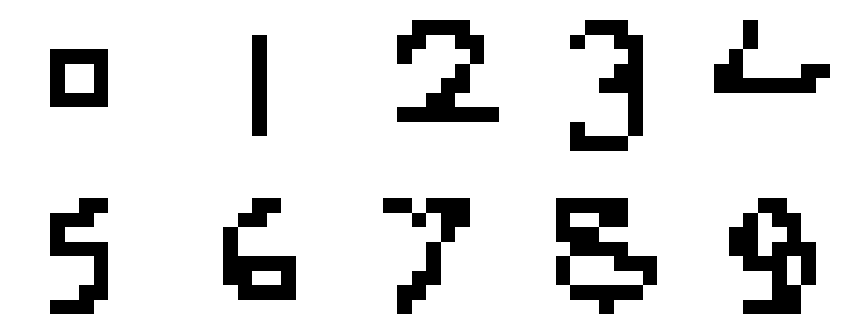

In [27]:
df = []
plt.figure(figsize=(ppg.PLOT_WIDTH, ppg.PLOT_HEIGHT))
for i in range(len(sol_num)):
    plt.subplot(2,5,i+1)
    plt.imshow(seqeval.draw_digit(sol_num[i], ppg.LOW_RESOLUTION_IMG_SIZE),cmap='gray')
    plt.axis('off')
    df.append(pd.DataFrame(sol_num[i], columns=['x','y']))

In [28]:
for i in range(ppg.NO_DIGITS):
    df[i].to_csv('..\\data\\pathgen out\\path_Num_ea_'+str(i)+'.csv')

In [ ]:
# hello = np.array(['a', 'b', 'c'])
# world = np.array([1, 2])
# hello[world]

In [ ]:
# for i in range(np.array([1, 2, 3, 4, 5]).shape[0]):
#     print(i)

In [ ]:
# a= np.array([i for i in range(10)])
# b= np.cumsum(a)
# print(b)

In [ ]:
# a[a>5]

In [ ]:
# b[a>5]

In [ ]:
# b[b>5]

In [ ]:
# b[-1]

In [ ]:
# b[[1,4,3]]

In [ ]:
# list(b)

In [ ]:
# def swap1(a):
#     a[0],a[1] = a[1],a[0]

# a = [0, 1]
# swap1(a)
# print(a)

In [ ]:
# a[0:2]

In [ ]:
# a = [1, 2, 4, 5, 6, 7]
# a[2:6][::-1]

In [ ]:
# a = [(1,2)]
# (2, 1) in a

In [ ]:
# a = [1, 2, 3, 4, 5]
# b = []
# b.append(a)
# b.append(a)
# b

In [ ]:
# a= [1,2,3,4,5,6,7,8,9]
# b = a
# b[2:5] = [2222]
# print(a)

In [ ]:
# a= [1,2,3,4,5,6,7,8,9]
# b = a[:]
# b[2:5] = [2222]
# print(a)
# print(b)

In [ ]:
# partially_mapped_crossover([list(range(1,10)),[9,3,7,8,2,6,5,1,4]],get_parents_pair_nodup)

In [ ]:
# np.array([-1]*8) + 1

In [ ]:
# chrom_size = 10
# table = [[] for i in range(chrom_size)]
# print(table)
# table[1].append((2,False))
# table[1].append((3,True))
# print(table)

In [ ]:
# a = [(x, True) for x in range(10)]
# a.remove((1, True))
# print(a)
# a.remove()

In [ ]:
# a = [[],[]]
# a.empty()

In [ ]:
# random.choice([])

In [ ]:
# a = [1, 2, 4]
# b = np.cumsum(a)
# print(a)
# print(b)
# type(b)

In [ ]:
# for i in range(50):
#     r =random.randint(0,10)
#     print(r)

In [ ]:
# print(f'hello %.2f%%'%10.234)

In [ ]:
# ll = [(5,[1,1,1,2]),(6,[1,1,1,2]),(1,[1,1,1,2]),(3,[1,1,1,2]),(2,[1,1,1,2])]
# x = sorted(ll,reverse=True)[:3]

In [ ]:
# [y[1] for y in x]